# Imports

In [1]:
import numpy as onp
import matplotlib.pyplot as plt

In [2]:
%%capture
!pip install jax-md
!pip install optax
!pip install equinox
import jax.numpy as np

In [3]:
%cd ..

/net/fs-brenner01/srv/export/brenner_lab/share/Lab/morphogenesis/jax-morph


In [4]:
from jax import random, vmap
from jax_md import space, quantity 
from jax_morph import datastructures, visualization, cell_division, cell_growth, simulation
from Francesco.chem_twotypes import initial_states, secdiff
from Francesco.chem_twotypes import divrates as divrates_chem
from Ramya.mech_homogeneous_growth import chemical, mechanical, divrates, optimize
from functools import partial
import equinox as eqx

In [5]:
import haiku

In [6]:
# The warnings annoy me :(
import warnings
warnings.filterwarnings('ignore')

In [7]:
%load_ext autoreload
%autoreload 2

# Params

In [8]:
def _maybe_array(name, value, train_params):
    if train_params[name]:
        return np.array(value)
    else:
        return value

In [9]:
#@title Define Params
# Define parameters --blue particles are type 1, orange are type 2
# keep type casting to place vars in gpu memory

# Number of chemical signals
n_chem = 2      


### CELL DIMENSIONS
cellRad = .5
cellRadBirth = float(cellRad / np.sqrt(2))


### DIFFUSION

# No diffusion or secretion in my simulation - only external chemical field over positions
diffCoeff = np.ones(n_chem) 
degRate = np.ones(n_chem) 
           
# diffusion cutoff
r_cutoffDiff = 5.*cellRad
r_onsetDiff = r_cutoffDiff - .5

# CHEMICAL FIELD
chem_max = 100.0
chem_k = 2.0
chem_gamma = 0.4

### SECRETION

# sec rate that gives concentration 1 at source at SS
sec_max_unitary = 2*np.sqrt(diffCoeff*degRate)

sec_max = sec_max_unitary*np.ones((n_chem,), dtype=np.float32)
#sec_max = sec_max.at[0].set(10)

sec_gamma = np.ones((n_chem,n_chem), dtype=np.float32) #was 0.01
sec_k = np.ones((n_chem,n_chem), dtype=np.float32) 
#secreted_by_ctypes = np.ones((n_chem, 1))
ctype_sec_chem = np.ones((1, n_chem))

# GROWTH

div_gamma = np.append(
    np.array([0.001, -0.001]),
    0.5*np.ones(n_chem)
)
div_k = np.append(
    np.array([-20.0, 20.0]),
    -6.0*np.ones(n_chem)
)


# MORSE POTENTIAL
# always use python scalars
alpha = 3.
eps_TwoTwo = 2. #orange
eps_OneOne = 2. #blue
eps_OneTwo = 2. 

# morse cutoff
r_cutoff = 4.*cellRad
r_onset = r_cutoff - .2


# number of gradient descent steps for Morse potential minimization
mech_relaxation_steps = 10


# Initialization and number of added cells. 
ncells_init = 100 #number of cells in the initial cluster
n_ones_init = 100 #number of type-1 cell in the initail cluster
ncells_add = 100

In [10]:
#@title Define trainable params
train_params = {
    'n_chem': False,
    
    'sec_max': False,
    'sec_gamma': False,
    'sec_k' : False,
    'ctype_sec_chem': False,
    
    'div_gamma' : False,
    'div_k' : False,
    
    'cellRad' : False,
    'cellRadBirth' : False,
    
    'diffCoeff' : True,
    'degRate' : False,
    'r_onsetDiff' : False,
    'r_cutoffDiff' : False,
    
    'alpha': False, 
    'eps_TwoTwo': False, 
    'eps_OneOne' : False,
    'eps_OneTwo' : False,
    'r_onset' : False,
    'r_cutoff' : False,
    'mech_relaxation_steps' : False,
    
    'ncells_init' : False,
    'n_ones_init': False, 
    'ncells_add': False,

    'chem_max': False, 
    'chem_k': False,
    'chem_gamma': False
}

In [11]:
#@title Initialize params
params = {
    'n_chem': n_chem,
    
    'sec_max': sec_max,
    'sec_gamma': sec_gamma,
    'sec_k' : sec_k,
    'ctype_sec_chem' : ctype_sec_chem,
    'div_gamma' : div_gamma,
    'div_k' : div_k,
    
    'cellRad' : cellRad,
    'cellRadBirth' : cellRadBirth,
    
    'diffCoeff' : diffCoeff,
    'degRate' : degRate,
    'r_onsetDiff' : r_onsetDiff,
    'r_cutoffDiff' : r_cutoffDiff,
    
    'alpha': _maybe_array('alpha', alpha, train_params), 
    'eps_TwoTwo': _maybe_array('eps_TwoTwo', eps_TwoTwo, train_params), 
    'eps_OneOne' : _maybe_array('eps_OneOne', eps_OneOne, train_params),
    'eps_OneTwo' : _maybe_array('eps_OneTwo', eps_OneTwo, train_params),
    'r_onset' : r_onset,
    'r_cutoff' : r_cutoff,
    'mech_relaxation_steps' : mech_relaxation_steps,
    
    'ncells_init' : ncells_init,
    'n_ones_init': n_ones_init, 
    'ncells_add': ncells_add,

    'chem_max': chem_max,
    'chem_k': chem_k,
    'chem_gamma': chem_gamma
}

# Set up simulation

In [12]:
key = random.PRNGKey(15)
fspace = datastructures.SpaceFunc(*space.free())
istate = initial_states.init_state_grow(key, params, fspace)
istate = chemical.S_fixed_chemfield(istate, params, fspace)

In [13]:
# init division nn
DIV_HIDDEN = 5
div_init, div_nn_apply = divrates.div_nn(params,train_params=train_params,n_hidden=DIV_HIDDEN,train=True)
params, train_params = div_init(istate, key)

In [14]:
#init secretion nn
SEC_HIDDEN = 5
use_state_fields=datastructures.CellState(*tuple([False]*3+[True]+[False]*4))
sec_init, sec_nn_apply = secdiff.sec_nn(params,train_params,SEC_HIDDEN, train=True, use_state_fields=use_state_fields)
params, train_params = sec_init(istate, key)

In [15]:
fstep = [
    cell_division.S_cell_division,
    cell_growth.S_grow_cells,
    mechanical.S_mechmin_twotypes,
    partial(secdiff.S_ss_chemfield, sec_fn=sec_nn_apply),
    chemical.S_fixed_chemfield,
    divrates.S_set_stress,
    partial(divrates_chem.S_set_divrate, divrate_fn=eqx.filter_jit(div_nn_apply))
]
sim_init, sim_step = simulation.simulation(fstep, params, fspace)

In [16]:
%%time
# run entire simulation
fstate, state_all = simulation.sim_trajectory(istate, sim_init, sim_step, key=key, history=True)

CPU times: user 1.93 s, sys: 349 ms, total: 2.28 s
Wall time: 2.72 s


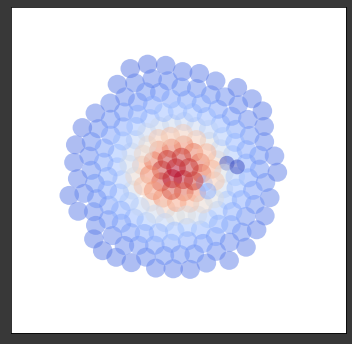

In [17]:
visualization.draw_circles_divrate(fstate)

# Scaled Gradient

In [18]:
import jax_md.dataclasses as jax_dataclasses

In [19]:
# Scaling params: 
# Want to reach 50/e at about 4 units
# Every time cell divides, adds about 0.03 units 
def S_scaled_chemfield(state,
                  params,
                  fspace,
                  noise=0.0,
                  **kwargs 
                  ) -> datastructures.CellState:
    """
  Fixed morphogen field based on particle position from center cell.
  Arg:
    state: current state
    param: dictionary with parameters
  Returns:
    big_state_output: CellState with updated chemical concentration
  """
    # Find displacements from center of cluster.
    center = np.array([0.0, 0.0])
    chemfield_disp = vmap(fspace.displacement, (0, None))(state.position, center)
    chemfield_disp = np.linalg.norm(chemfield_disp, axis=1)
    # Get tissue size
    L = state.position[:, 0].max() - state.position[:, 0].min()
    chemfield = 50*np.exp(-chemfield_disp*2/L)
    #chemfield = np.where(state.celltype > 0, chemfield, 0.0) + noise*random.normal(state.key, chemfield.shape)
    state = jax_dataclasses.replace(state, field=chemfield)
    return state

In [20]:
fstep = [
    cell_division.S_cell_division,
    cell_growth.S_grow_cells,
    mechanical.S_mechmin_twotypes,
    partial(secdiff.S_ss_chemfield, sec_fn=sec_nn_apply),
    S_scaled_chemfield,
    divrates.S_set_stress,
    partial(divrates_chem.S_set_divrate, divrate_fn=eqx.filter_jit(div_nn_apply))
]
sim_init, sim_step = simulation.simulation(fstep, params, fspace)

In [21]:
istate = S_scaled_chemfield(istate, params, fspace)
fstate, state_all = simulation.sim_trajectory(istate, sim_init, sim_step, key=key, history=True)

<AxesSubplot:>

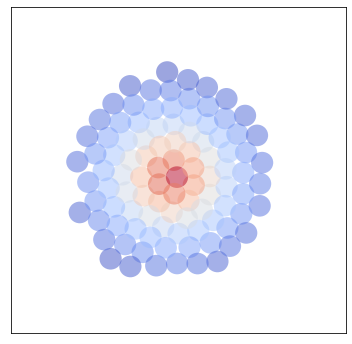

In [22]:
visualization.draw_circles(istate, istate.field)

<AxesSubplot:>

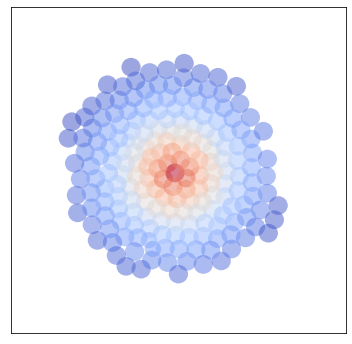

In [23]:
visualization.draw_circles(fstate, fstate.field)

# Optimization

In [24]:
import optax
from jax import value_and_grad, lax
from Ramya.mech_homogeneous_growth.optimize import avg_loss

In [25]:
use_state_fields_sec=datastructures.CellState(*tuple([False]*3+[True]+[False]*4))
use_state_fields_div=datastructures.CellState(*tuple([False]*3+[True, False]+[False, True, False]))
sec_init, sec_nn_apply = secdiff.sec_nn(params,train_params,SEC_HIDDEN, use_state_fields=use_state_fields_sec, train=False)
div_init, div_nn_apply = divrates.div_nn(params,train_params=train_params,n_hidden=DIV_HIDDEN, use_state_fields=use_state_fields_div, train=True)
params, train_params = sec_init(istate, key)
params, train_params = div_init(istate, key)
train_params["diffCoeff"] = True

In [63]:
train_params

{'n_chem': False,
 'sec_max': False,
 'sec_gamma': False,
 'sec_k': False,
 'ctype_sec_chem': False,
 'div_gamma': False,
 'div_k': False,
 'cellRad': False,
 'cellRadBirth': False,
 'diffCoeff': True,
 'degRate': False,
 'r_onsetDiff': False,
 'r_cutoffDiff': False,
 'alpha': False,
 'eps_TwoTwo': False,
 'eps_OneOne': False,
 'eps_OneTwo': False,
 'r_onset': False,
 'r_cutoff': False,
 'mech_relaxation_steps': False,
 'ncells_init': False,
 'n_ones_init': False,
 'ncells_add': False,
 'chem_max': False,
 'chem_k': False,
 'chem_gamma': False,
 'div_fn': {'mlp/~/linear_0': {'b': True, 'w': True},
  'mlp/~/linear_1': {'b': True, 'w': True}},
 'sec_fn': {'mlp/~/linear_0': {'b': False, 'w': False},
  'mlp/~/linear_1': {'b': False, 'w': False}}}

In [26]:
fstep = [
    cell_division.S_cell_division,
    cell_growth.S_grow_cells,
    mechanical.S_mechmin_twotypes,
    partial(secdiff.S_ss_chemfield, sec_fn=sec_nn_apply),
    S_scaled_chemfield,
    divrates.S_set_stress,
    partial(divrates_chem.S_set_divrate, divrate_fn=eqx.filter_jit(div_nn_apply))
]

Will have to use loss at every time step for this - otherwise it could just overfit to the field at the last timestep

In [27]:
@eqx.filter_jit
@eqx.filter_vmap(default=None, kwargs=dict(sim_key=0))
def shape_loss_fr(params, 
            hyper_params,
            fstep,
            fspace,
            istate,
            sim_key=None,
            metric_fn=None,
            target_metric=0.,
            REINFORCE=True,
            GAMMA=.95,
            TEST=False,
           ):
    '''
    REINFORCE loss with discounting.  
    '''
    
    def _sim_trajectory(istate, sim_init, sim_step, ncells_add, key=None):

        state = sim_init(istate, ncells_add, key)

        def scan_fn(state, i):
            state, logp = sim_step(state)
            loss = np.sum((metric_fn(state) - target_metric)**2)
            loss = np.sqrt(loss)
            return state, (logp, loss)


        iterations = len(state.celltype)-len(istate.celltype)
        iterations = np.arange(iterations)
        fstate, aux = lax.scan(scan_fn, state, iterations)

        return fstate, aux

    # merge params dicts
    all_params = eqx.combine(params, hyper_params)
    
    #simulation length
    ncells_add = all_params['ncells_add']


    #forward pass - simulation
    sim_init, sim_step = simulation.simulation(fstep, all_params, fspace)
    fstate, (logp, losses) = _sim_trajectory(istate, sim_init, sim_step, ncells_add, sim_key)


    
    if REINFORCE:
        
        def _returns_rec(losses):
            Gs=[]
            G=0
            i=0
            for l in losses[::-1]:
                G = l+G*GAMMA
                Gs.append(G)
                i += 1

            return np.array(Gs)[::-1]
        
        iloss = np.sqrt(np.sum((metric_fn(istate) - target_metric)**2))
        rewards = -np.diff(np.append(np.array([iloss]),losses))
        
        #discount rewards
        returns = _returns_rec(rewards)
        
        loss = -np.sum(logp*lax.stop_gradient(returns))#+rewards.sum()
        
        return loss
    
    if TEST:
        return losses, rewards, logp

    else:
        return np.sum(losses)

In [28]:
key = random.PRNGKey(5)

In [49]:
EPOCHS = 30
EPISODES_PER_UPDATE = 50 #128
EPISODES_PER_EVAL = 50 #128
LEARNING_RATE = 0.01
METRIC_FN = optimize.cv_divrates
TARGET_METRIC = 0.0


rloss = partial(shape_loss_fr, metric_fn=METRIC_FN, target_metric=TARGET_METRIC, REINFORCE=True)
sloss = partial(shape_loss_fr, metric_fn=METRIC_FN, target_metric=TARGET_METRIC, REINFORCE=False)
p, hp = eqx.partition(params, train_params)

# init optimizer
optimizer = optax.chain(optax.clip_by_global_norm(1.0), optax.adam(LEARNING_RATE)) 
opt_state = optimizer.init(p)


#--------------------------------------------
#store loss at initial params and calc grad 

key, *batch_subkeys = random.split(key, EPISODES_PER_UPDATE+1)
batch_subkeys = np.array(batch_subkeys)
ll, grads = value_and_grad(avg_loss)(p, hp, rloss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)
key, *eval_subkeys = random.split(key, EPISODES_PER_EVAL+1)
eval_subkeys = np.array(eval_subkeys)
l = avg_loss(p, hp, sloss, eval_subkeys, fstep=fstep, fspace=fspace, istate=istate)

#store initial params and loss
loss_t = [float(l)]
params_t = [p]

#--------------------------------------------


for t in range(EPOCHS):
    
    #generate batch of random keys
    key, *batch_subkeys = random.split(key, EPISODES_PER_UPDATE+1)
    batch_subkeys = np.array(batch_subkeys)
    # sgd step
    updates, opt_state = optimizer.update(grads, opt_state, p)

    p = eqx.apply_updates(p, updates)
    
    if None != p['diffCoeff']:
        p['diffCoeff'] = np.where(p['diffCoeff']>.2,p['diffCoeff'],.2)
    
    #estimate actual avg loss
    key, *eval_subkeys = random.split(key, EPISODES_PER_EVAL+1)
    eval_subkeys = np.array(eval_subkeys)

    l = avg_loss(p, hp, sloss, eval_subkeys, fstep=fstep, fspace=fspace, istate=istate)    
    # surrogate loss and grads
    ll, grads = value_and_grad(avg_loss)(p, hp, rloss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)
    #store
    loss_t += [float(l)]
    params_t += [p]
    grads_t += [grads]
    print(float(l))

67.16500854492188
65.92069244384766
66.8288345336914
66.87960815429688
66.76354217529297
67.23065185546875
67.55207061767578
68.0369873046875
68.56171417236328
68.99038696289062
69.49433135986328
69.55624389648438
69.2195816040039
68.55956268310547
68.23900604248047
67.81124114990234
67.5216293334961
67.21682739257812
66.87860107421875
66.4552230834961
66.28722381591797
66.26820373535156
65.97061157226562
65.793701171875
65.72518157958984
65.41905212402344
65.5550537109375
65.601806640625
65.6261215209961
65.7313003540039


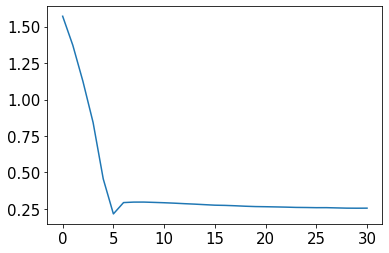

In [40]:
plt.plot(loss_t)

In [43]:
opt_params = eqx.combine(params_t[-1], params)
sim_init, sim_step = simulation.simulation(fstep, opt_params, fspace)
# run entire simulation
fstate_opt, state_all_opt = simulation.sim_trajectory(istate, sim_init, sim_step, key=key, history=True)

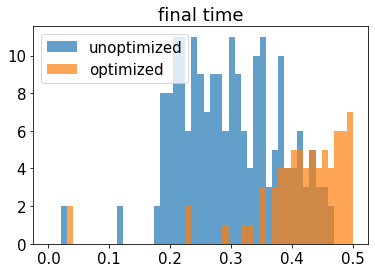

In [44]:
plt.hist(fstate.divrate.tolist(), bins=np.linspace(0.0, 0.5, 50), label="unoptimized", alpha=0.7)
plt.hist(fstate_opt.divrate.tolist(), bins=np.linspace(0.0, 0.5, 50), label="optimized", alpha=0.7)
plt.legend();
plt.title("final time");

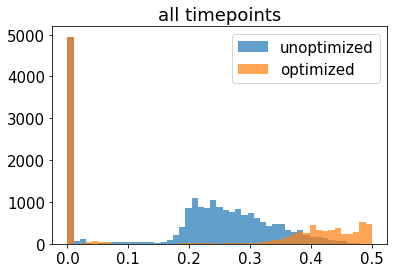

In [45]:
plt.hist(state_all[0].divrate.flatten().tolist(), bins=np.linspace(0.0, 0.5, 50), label="unoptimized", alpha=0.7)
plt.hist(state_all_opt[0].divrate.flatten().tolist(), bins=np.linspace(0.0, 0.5, 50), label="optimized", alpha=0.7)
plt.legend();
plt.title("all timepoints");

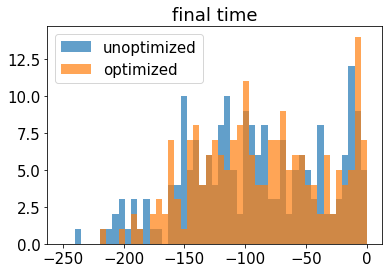

In [46]:
plt.hist(fstate.stress.tolist(), label="unoptimized", alpha=0.7, bins=np.linspace(-250, 0, 50))
plt.hist(fstate_opt.stress.tolist(), label="optimized", alpha=0.7, bins=np.linspace(-250, 0, 50))
plt.legend();
plt.title("final time");

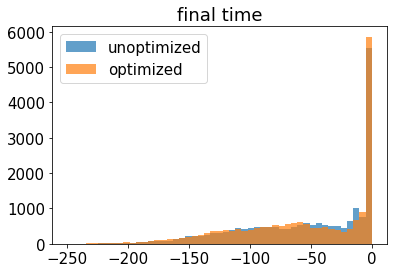

In [47]:
plt.hist(state_all[0].stress.flatten().tolist(), label="unoptimized", alpha=0.7, bins=np.linspace(-250, 0, 50))
plt.hist(state_all_opt[0].stress.flatten().tolist(), label="optimized", alpha=0.7, bins=np.linspace(-250, 0, 50))
plt.legend();
plt.title("final time");

In [48]:
import seaborn as sns

In [53]:
stresses = np.tile(np.linspace(-250, -10, 20), 20)
chemicals_one = np.vstack((np.repeat(np.linspace(0.0, 10.0, 20), 20), 
                           5.0*np.ones(400))).T
chemicals_two = np.vstack((3.0*np.ones(400), 
                           np.repeat(np.linspace(0.0, 20.0, 20), 20))).T
chemicals_all = np.vstack((np.tile(np.linspace(0.0, 10.0, 20), 20), 
                           np.repeat(np.linspace(0.0, 20.0, 20), 20))).T

In [54]:
# generate fake cell state to test output of network on different stress values
def fake_cell_state(stresses, chemicals, N=400):    
    celltype = np.ones(N, dtype=np.int16)
    radius = np.ones(N, dtype=np.float32)    
    position = np.zeros((N,2), dtype=np.float32)
    field = np.zeros(N, dtype=np.float32)
    divrate = np.zeros(N, dtype=np.float32)
    fake_state = datastructures.CellState(position, celltype, radius, chemicals, field, divrate, stresses, key)
    return fake_state

In [55]:
state_one = fake_cell_state(stresses, chemicals_one, 400)
state_two = fake_cell_state(stresses, chemicals_two, 400)
state_all = fake_cell_state(np.ones(400)*-100.0, chemicals_all, 400)

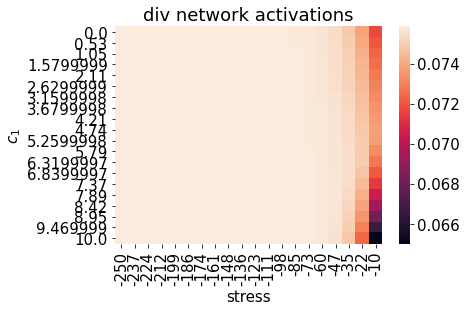

In [56]:
outputs_one = div_nn_apply(state_one, opt_params)
sns.heatmap(outputs_one.reshape(20,20), xticklabels=np.linspace(-250, -10, 20).astype(int), yticklabels=np.around(np.linspace(0.0, 10.0, 20), decimals=2))
plt.xlabel("stress")
plt.ylabel("$c_1$");
plt.title('div network activations');

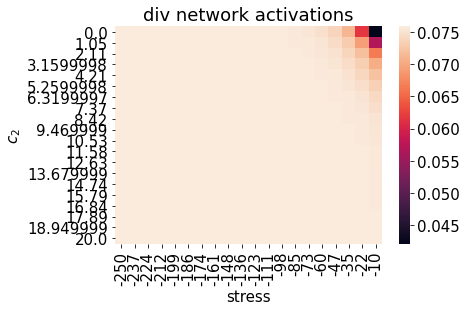

In [61]:
outputs_two = div_nn_apply(state_two, opt_params)
sns.heatmap(outputs_two.reshape(20,20), xticklabels=np.linspace(-250, -10, 20).astype(int), yticklabels=np.around(np.linspace(0.0, 20.0, 20), decimals=2))
plt.xlabel("stress")
plt.ylabel("$c_2$");
plt.title('div network activations');

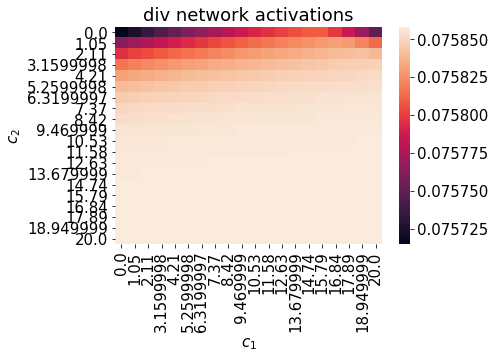

In [62]:
outputs_all = div_nn_apply(state_all, opt_params)
sns.heatmap(outputs_all.reshape(20,20), xticklabels=np.around(np.linspace(0.0, 20.0, 20), decimals=2), yticklabels=np.around(np.linspace(0.0, 20.0, 20), decimals=2))
plt.xlabel("$c_1$")
plt.ylabel("$c_2$");
plt.title('div network activations');

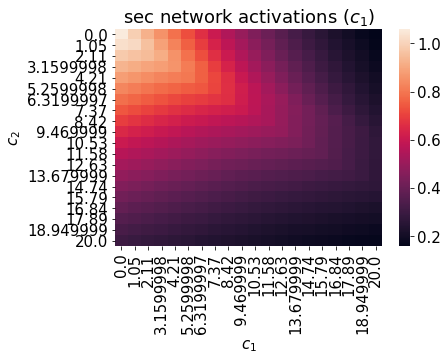

In [63]:
outputs_all = sec_nn_apply(state_all, opt_params)
sns.heatmap(outputs_all[:, 0].reshape(20,20), xticklabels=np.around(np.linspace(0.0, 20.0, 20), decimals=2), yticklabels=np.around(np.linspace(0.0, 20, 20), decimals=2))
plt.xlabel("$c_1$")
plt.ylabel("$c_2$");
plt.title('sec network activations ($c_1$)');

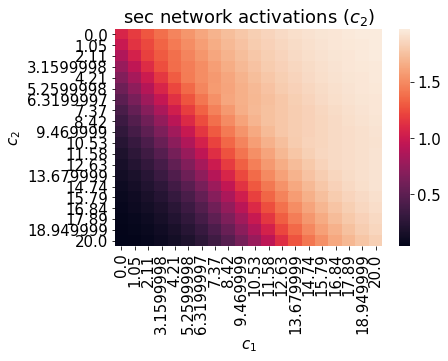

In [64]:
outputs_all = sec_nn_apply(state_all, opt_params)
sns.heatmap(outputs_all[:, 1].reshape(20,20), xticklabels=np.around(np.linspace(0.0, 20.0, 20), decimals=2), yticklabels=np.around(np.linspace(0.0, 20, 20), decimals=2))
plt.xlabel("$c_1$")
plt.ylabel("$c_2$");
plt.title('sec network activations ($c_2$)');

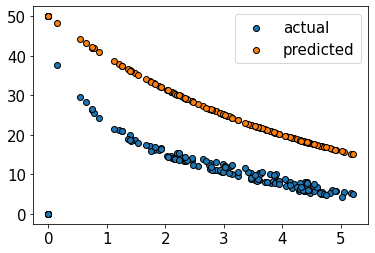

In [29]:
# Plot for time i 
i = 40
chemfield_disp = vmap(fspace.displacement, (0, None))(state_all[0].position[i], np.array([0.0, 0.0]))
chemfield_disp = np.linalg.norm(chemfield_disp, axis=1)
L = state_all[0].position[i, :, 0].max() - state_all[0].position[i, :, 0].min()
target_gradient = 50.0*np.exp(-chemfield_disp*2/L)
plt.scatter(chemfield_disp, state_all[0].chemical[i, :, 0], edgecolors='black', label="actual")
plt.scatter(chemfield_disp, target_gradient, edgecolors='black', label="predicted")
plt.legend();

In [36]:
def chemical_loss(state):
    center = np.array([0.0, 0.0])
    chemfield_disp = vmap(fspace.displacement, (0, None))(state.position, center)
    chemfield_disp = np.linalg.norm(chemfield_disp, axis=1)
    L = state.position[:, 0].max() - state.position[:, 0].min()
    max_chem = state.chemical[:, 0].max()
    chemfield = max_chem*np.exp(-chemfield_disp*2/L)
    metric_fn = state.chemical[:, 0] - chemfield
    metric_fn = np.where(state.celltype > 0, metric_fn, 0.0)
    return metric_fn

In [37]:
use_state_fields_sec=datastructures.CellState(*tuple([False]*3+[True]+[False]*4))
use_state_fields_div=datastructures.CellState(*tuple([False]*3+[True, False]+[False, True, False]))
sec_init, sec_nn_apply = secdiff.sec_nn(params,train_params,SEC_HIDDEN, use_state_fields=use_state_fields_sec, train=True)
div_init, div_nn_apply = divrates.div_nn(params,train_params=train_params,n_hidden=DIV_HIDDEN, use_state_fields=use_state_fields_div, train=False)
params, train_params = sec_init(istate, key)
params, train_params = div_init(istate, key)
train_params["diffCoeff"] = True
train_params["sec_max"] = True
train_params["degRate"] = True

In [39]:
EPOCHS = 20
EPISODES_PER_UPDATE = 30 #128
EPISODES_PER_EVAL = 30 #128
LEARNING_RATE = 0.01
METRIC_FN = chemical_loss
TARGET_METRIC = 0.0


rloss = partial(shape_loss_fr, metric_fn=METRIC_FN, target_metric=TARGET_METRIC, REINFORCE=True)
sloss = partial(shape_loss_fr, metric_fn=METRIC_FN, target_metric=TARGET_METRIC, REINFORCE=False)
p, hp = eqx.partition(params, train_params)

# init optimizer
optimizer = optax.chain(optax.clip_by_global_norm(1.0), optax.adam(LEARNING_RATE)) 
opt_state = optimizer.init(p)


#--------------------------------------------
#store loss at initial params and calc grad 

key, *batch_subkeys = random.split(key, EPISODES_PER_UPDATE+1)
batch_subkeys = np.array(batch_subkeys)
ll, grads = value_and_grad(avg_loss)(p, hp, sloss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)
key, *eval_subkeys = random.split(key, EPISODES_PER_EVAL+1)
eval_subkeys = np.array(eval_subkeys)
l = avg_loss(p, hp, sloss, eval_subkeys, fstep=fstep, fspace=fspace, istate=istate)

#store initial params and loss
loss_t = [float(l)]
params_t = [p]
grads_t = [grads]
#--------------------------------------------


for t in range(EPOCHS):
    
    #generate batch of random keys
    key, *batch_subkeys = random.split(key, EPISODES_PER_UPDATE+1)
    batch_subkeys = np.array(batch_subkeys)
    # sgd step
    updates, opt_state = optimizer.update(grads, opt_state, p)

    p = eqx.apply_updates(p, updates)
    
    if None != p['diffCoeff']:
        p['diffCoeff'] = np.where(p['diffCoeff']>.2,p['diffCoeff'],.2)
    
    #estimate actual avg loss
    key, *eval_subkeys = random.split(key, EPISODES_PER_EVAL+1)
    eval_subkeys = np.array(eval_subkeys)

    l = avg_loss(p, hp, sloss, eval_subkeys, fstep=fstep, fspace=fspace, istate=istate)    
    # surrogate loss and grads
    ll, grads = value_and_grad(avg_loss)(p, hp, sloss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)
    #store
    loss_t += [float(l)]
    params_t += [p]
    grads_t += [grads]
    print(float(l))

7200.7099609375
7033.71923828125
6864.30859375
6564.47607421875
6757.25048828125
6357.9111328125
6145.5859375
6118.86083984375
6125.42529296875
5900.16259765625
5723.3515625
5618.3056640625
5461.5283203125
5350.466796875
5069.47802734375
5161.0595703125
4969.84716796875
4989.26904296875
4702.50048828125
4654.4853515625


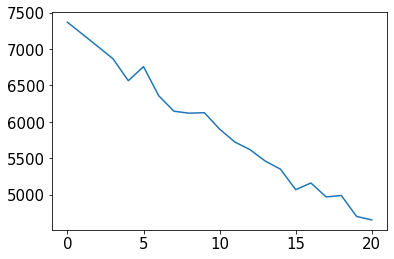

In [40]:
plt.plot(loss_t)

In [41]:
opt_params = eqx.combine(params_t[-1], params)
sim_init, sim_step = simulation.simulation(fstep, opt_params, fspace)
# run entire simulation
fstate_opt, state_all_opt = simulation.sim_trajectory(istate, sim_init, sim_step, key=key, history=True)

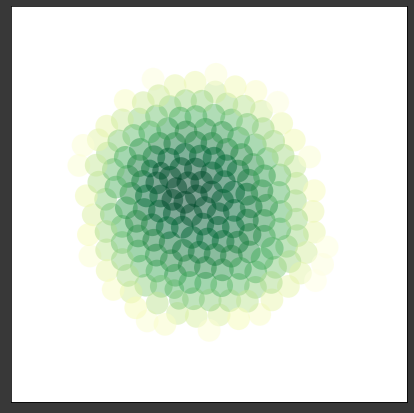

In [42]:
visualization.draw_circles_chem(fstate);

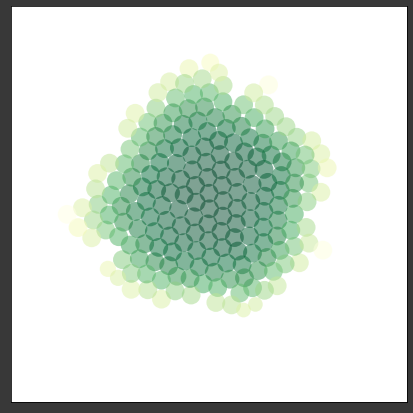

In [43]:
visualization.draw_circles_chem(fstate_opt);

In [44]:
def plot_field(state_position, state_chemical, color):
    center = np.array([0.0, 0.0])
    chemfield_disp = vmap(fspace.displacement, (0, None))(state_position, center)
    chemfield_disp = np.linalg.norm(chemfield_disp, axis=1)
    sorted_list = np.array(sorted(zip(chemfield_disp, state_chemical), key=lambda x: x[0]))
    plt.plot(sorted_list[:, 0], sorted_list[:, 1], c=color)

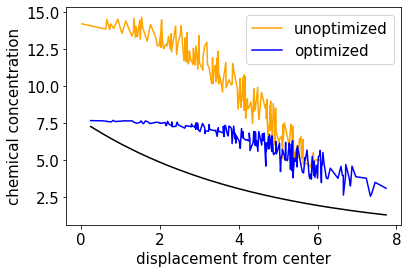

In [47]:
plot_field(fstate.position, fstate.chemical[:, 0], 'orange');
plot_field(fstate_opt.position, fstate_opt.chemical[:, 0], 'blue');
chemfield_disp = vmap(fspace.displacement, (0, None))(fstate_opt.position, np.array([0.0, 0.0]))
chemfield_disp = np.linalg.norm(chemfield_disp, axis=1)
predicted = fstate_opt.chemical[:, 0].max()*np.exp(-chemfield_disp*2/L)
plot_field(fstate_opt.position, predicted, 'black');
plt.xlabel("displacement from center")
plt.ylabel("chemical concentration")
plt.legend(["unoptimized", "optimized"]);

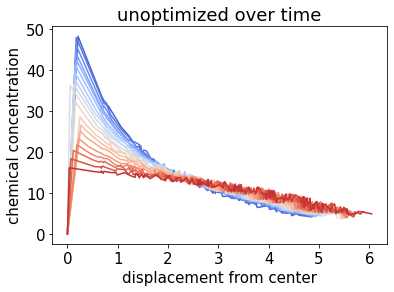

In [48]:
for i in range(5, len(state_all[0].position), 5):
    plot_field(state_all[0].position[i], state_all[0].chemical[i, :, 0], plt.cm.coolwarm(i/len(state_all_opt[0].position)));
plt.xlabel("displacement from center")
plt.ylabel("chemical concentration")
plt.title("unoptimized over time");

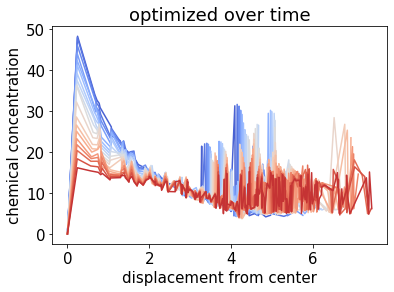

In [49]:
for i in range(5, len(state_all_opt[0].position), 5):
    plot_field(state_all_opt[0].position[i], state_all[0].chemical[i, :, 0], plt.cm.coolwarm(i/len(state_all_opt[0].position)));
plt.xlabel("displacement from center")
plt.ylabel("chemical concentration")
plt.title("optimized over time");

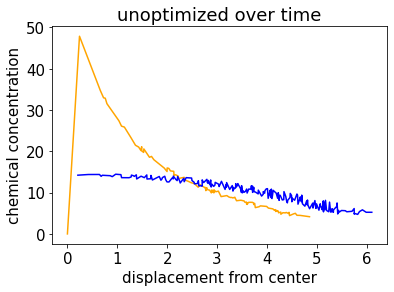

In [61]:
plot_field(state_all[0].position[3], state_all[0].chemical[3, :, 0], 'orange');
plot_field(state_all[0].position[-1], state_all[0].chemical[-1, :, 0], 'blue');
plt.xlabel("displacement from center")
plt.ylabel("chemical concentration")
plt.title("unoptimized over time");

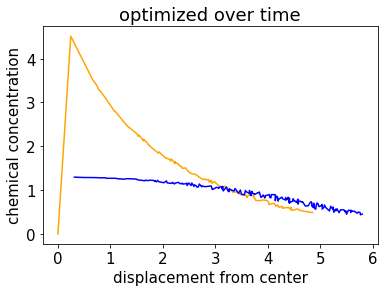

In [62]:
plot_field(state_all_opt[0].position[3], state_all_opt[0].chemical[3, :, 0], 'orange');
plot_field(state_all_opt[0].position[-1], state_all_opt[0].chemical[-1, :, 0], 'blue');
plt.xlabel("displacement from center")
plt.ylabel("chemical concentration")
plt.title("optimized over time");

In [51]:
def make_cell_state(traj, idx):
    state = datastructures.CellState(traj.position[idx],
                                    traj.celltype[idx],
                                    traj.radius[idx],
                                    traj.chemical[idx],
                                    traj.field[idx],
                                    traj.divrate[idx],
                                    traj.stress[idx],
                                    traj.key)
    return state

<AxesSubplot:>

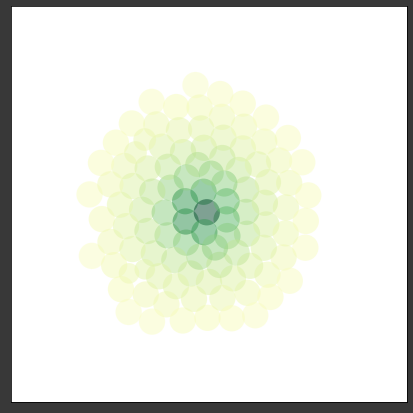

In [52]:
visualization.draw_circles_chem(make_cell_state(state_all[0], 3))

<AxesSubplot:>

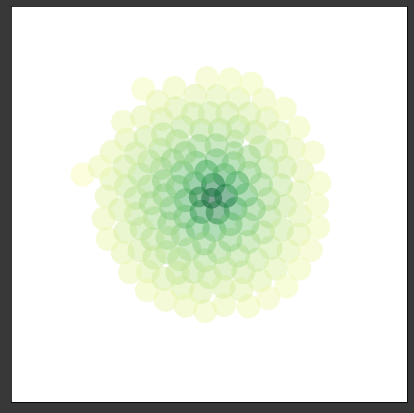

In [53]:
visualization.draw_circles_chem(make_cell_state(state_all[0], 50))

<AxesSubplot:>

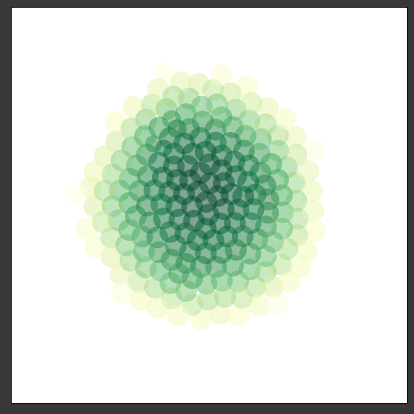

In [54]:
visualization.draw_circles_chem(make_cell_state(state_all[0], 100))

<AxesSubplot:>

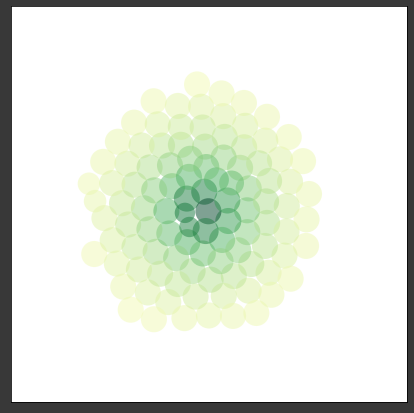

In [55]:
visualization.draw_circles_chem(make_cell_state(state_all_opt[0], 3))

<AxesSubplot:>

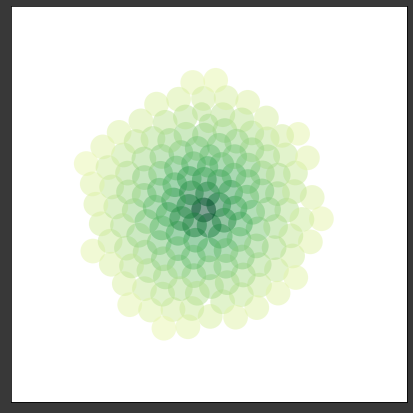

In [47]:
visualization.draw_circles_chem(make_cell_state(state_all_opt[0], 50))

<AxesSubplot:>

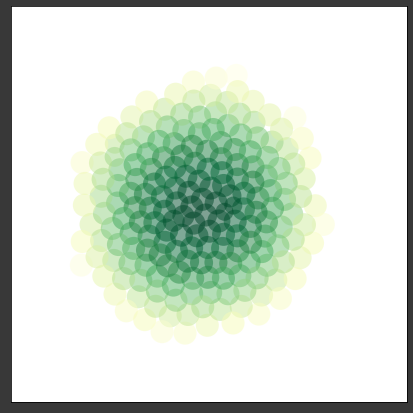

In [48]:
visualization.draw_circles_chem(make_cell_state(state_all_opt[0], 100))

In [59]:
opt_params

{'alpha': 3.0,
 'cellRad': 0.5,
 'cellRadBirth': 0.3535533845424652,
 'chem_gamma': 0.4,
 'chem_k': 2.0,
 'chem_max': 100.0,
 'ctype_sec_chem': DeviceArray([[1., 1.]], dtype=float32),
 'degRate': DeviceArray([1., 1.], dtype=float32),
 'diffCoeff': DeviceArray([2.0139267 , 0.86054915], dtype=float32),
 'div_fn': {'mlp/~/linear_0': {'b': DeviceArray([0., 0., 0., 0., 0.], dtype=float32),
   'w': DeviceArray([[ 0.85070515,  0.15866731,  0.04649664, -0.09903456,
                 -0.43765068],
                [-0.7479983 ,  0.8167781 , -0.36970127,  0.28848886,
                  0.99973875],
                [ 0.09079742,  0.85498995,  0.02925353,  0.32405347,
                  0.0327502 ]], dtype=float32)},
  'mlp/~/linear_1': {'b': DeviceArray([0.], dtype=float32),
   'w': DeviceArray([[ 0.02666416],
                [ 0.05393091],
                [-0.4024969 ],
                [-0.34721243],
                [-0.1637482 ]], dtype=float32)}},
 'div_gamma': DeviceArray([ 0.001, -0.001,  0.5  ,

In [56]:
import seaborn as sns
chemicals_all = np.vstack((np.tile(np.linspace(9, 12.0, 20), 20), 
                           np.repeat(np.linspace(4.0, 9.0, 20), 20))).T

In [57]:
stresses = np.tile(np.linspace(-250, -10, 20), 20)
state_all = fake_cell_state(stresses, chemicals_all, 400)
outputs_all = sec_nn_apply(state_all, opt_params)
sns.heatmap(outputs_all[:, 1].reshape(20,20), xticklabels=np.around(np.linspace(9, 12.0, 20), decimals=2), yticklabels=np.around(np.linspace(4.0, 9.0, 20), decimals=2))
plt.xlabel("$c_1$")
plt.ylabel("$c_2$");
plt.title('sec network activations ($c_2$)');

NameError: name 'fake_cell_state' is not defined

In [ ]:
stresses = np.tile(np.linspace(-250, -10, 20), 20)
state_all = fake_cell_state(stresses, chemicals_all, 400)
outputs_all = sec_nn_apply(state_all, opt_params)
sns.heatmap(outputs_all[:, 0].reshape(20,20), xticklabels=np.around(np.linspace(9, 12.0, 20), decimals=2), yticklabels=np.around(np.linspace(4.0, 9.0, 20), decimals=2))
plt.xlabel("$c_1$")
plt.ylabel("$c_2$");
plt.title('sec network activations ($c_1$)');

In [ ]:
opt_params["diffCoeff"]